In [100]:
import pandas as pd
from textblob import TextBlob
from textblob import Word
from gensim import corpora, models, similarities
import os
import tempfile
import gensim
from sklearn.linear_model import LinearRegression
import math
import numpy as np
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt

TEMP_FOLDER = tempfile.gettempdir()

In [2]:
#I scraped in two different runs so need to combine these datasources
#import original reviews and data
links = pd.read_csv('/Users/scottgleave/Downloads/DataMiningCourse/finalprojectdata/links2.csv', header = None)
text = pd.read_csv('/Users/scottgleave/Downloads/DataMiningCourse/finalprojectdata/reviewtext.csv', header = None)

In [3]:
#import second set of reviews/data
links2 = pd.read_csv('/Users/scottgleave/Downloads/DataMiningCourse/finalprojectdata/links3.csv', header = None)
text2 = pd.read_csv('/Users/scottgleave/Downloads/DataMiningCourse/finalprojectdata/reviewtext2.csv', header = None)

In [4]:
#prep 2nd set of data, which has lots of links that didn't work

links2[5] = text2
links2.drop_duplicates([5], inplace = True)
links2 = links2[links2[5] != '[]']
links2 = links2[links2[5] != '[]']
links2.dropna(subset = [5],inplace = True)

In [5]:
#add review text to rest of data
links[5] = text

In [6]:
#drop duplicate reviews (some reviews on both xbox,playstation, etc)
links.drop_duplicates([5], inplace = True)


In [7]:
#add two sets of data together
links = pd.concat([links,links2], axis = 0)
links = links.reset_index()
links = links.drop('index', axis = 1)

In [115]:
links.head()

,0,1,2,3,4,5,year
0,https://www.ign.com/articles/2018/11/17/battle...,7.5,PC,Shooter,2018-11-17,"[""With all of the development muscle behind EA...",2018
1,https://www.ign.com/articles/2018/11/15/sid-me...,9.4,Nintendo Switch,Strategy,2018-11-15,['When I first reviewed Civilization VI back i...,2018
2,https://www.ign.com/articles/2018/11/14/warfra...,8.6,PC,Shooter,2018-11-15,"[' ', 'There aren’t many games that make me fe...",2018
3,https://www.ign.com/articles/2018/11/14/overki...,5.3,PC,Action,2018-11-14,"['Overkill’s ', ' is an earnest attempt to del...",2018
4,https://www.ign.com/articles/2018/11/16/pokemo...,8.3,Nintendo Switch,RPG,2018-11-12,"[""It's often with rose-colored glasses that I ...",2018


# Exploration

In [106]:
#How many articles in corpus?
links.shape


(2903, 6)

In [107]:
#general distribution of scores
links[1].describe()

count    2903.000000
mean        7.326628
std         1.499496
min         1.500000
25%         6.500000
50%         7.500000
75%         8.500000
max        10.000000
Name: 1, dtype: float64

In [108]:
#What are count of top genres?
groupcount = links.groupby([3]).count()
groupcount.sort_values(by=[0], ascending = False).head(10)

,0,1,2,4,5
3,,,,,
Action,511,511,511,511,511
Adventure,324,324,324,324,324
Shooter,315,315,315,315,315
RPG,285,285,285,285,285
Strategy,177,177,177,177,177
Platformer,167,167,167,167,167
Sports,139,139,139,139,139
"Action, Adventure",122,122,122,122,122
Simulation,92,92,92,92,92


In [109]:
#How does mean score differ for top genres?
grouped = links.groupby([3]).count()
grouped.sort_values(by=[2],ascending = False, inplace = True)
cols = grouped[:10].index.get_level_values(0)
colslist = cols.tolist()
selected = links[links[3].isin(colslist)]
selected.groupby([3]).mean()

,1
3,
Action,6.977104
"Action, Adventure",7.644262
Adventure,7.359877
Platformer,7.629341
Puzzle,7.615909
RPG,7.545263
Shooter,7.162222
Simulation,6.900000
Sports,7.328777


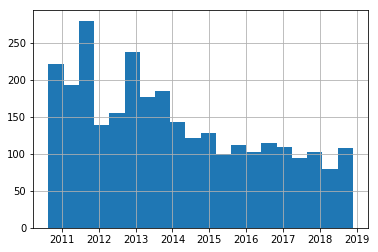

In [110]:
#What is time distribution of reviews?

links[4] = pd.to_datetime(links[4])
links[4].hist(bins=20)

Text(0.5,0,'Year')

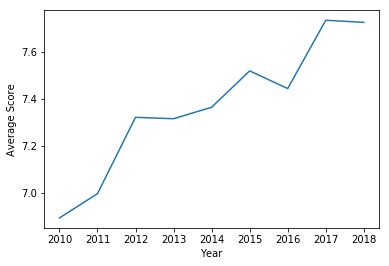

In [111]:
#how does average review score change over time?
links['year'] = links[4].dt.year
yearscore = links.groupby(['year']).mean()
yearscore.reset_index(inplace = True)
plt.plot(yearscore['year'], yearscore[1])
plt.ylabel('Average Score')
plt.xlabel('Year')

In [112]:
#What platforms are most common?

platformcount = links.groupby([2]).count().sort_values(by=[0], ascending = False)
platformcount.head(10)

,0,1,3,4,5,year
2,,,,,,
PC,927,927,924,927,927,927
PlayStation 3,489,489,488,489,489,489
PlayStation 4,315,315,315,315,315,315
Nintendo 3DS,227,227,226,227,227,227
Xbox One,199,199,199,199,199,199
iPhone,138,138,134,138,138,138
Xbox 360,120,120,120,120,120,120
Nintendo DSi,94,94,93,94,94,94
Wii U,90,90,90,90,90,90


In [114]:
#How do review scores differ accross platforms?

platformmean = links.groupby([2]).mean()
platformmean.sort_values(by=[1], ascending = False).drop(['year'], axis = 1)


,1
2,
Linux,8.366667
Macintosh,8.300000
Wii,8.100000
Web Games,8.000000
New Nintendo 2DS XL,8.000000
Nintendo Switch,7.998246
iPad,7.950000
Arcade,7.900000
Xbox One,7.610050


# Text Processing

In [9]:
#create df with only text features for processing
text = links[5]
text.shape

(2903,)

In [10]:
#lowercase text
text = text.apply(lambda x: " ".join(x.lower() for x in x.split()))
text.head()

0    ["with all of the development muscle behind ea...
1    ['when i first reviewed civilization vi back i...
2    [' ', 'there aren’t many games that make me fe...
3    ['overkill’s ', ' is an earnest attempt to del...
4    ["it's often with rose-colored glasses that i ...
Name: 5, dtype: object

In [11]:
#remove brackets
text = text.apply(lambda x: x[1:-1])
text.head()

0    "with all of the development muscle behind ea ...
1    'when i first reviewed civilization vi back in...
2    ' ', 'there aren’t many games that make me fee...
3    'overkill’s ', ' is an earnest attempt to deli...
4    "it's often with rose-colored glasses that i l...
Name: 5, dtype: object

In [12]:
#remove new line
text = text.replace(r'\\n','', regex=True)
text.head()

0    "with all of the development muscle behind ea ...
1    'when i first reviewed civilization vi back in...
2    ' ', 'there aren’t many games that make me fee...
3    'overkill’s ', ' is an earnest attempt to deli...
4    "it's often with rose-colored glasses that i l...
Name: 5, dtype: object

In [13]:
#remove punc
text = text.str.replace('[^\w\s]','')
text.head()

0    with all of the development muscle behind ea d...
1    when i first reviewed civilization vi back in ...
2      there arent many games that make me feel as ...
3    overkills   is an earnest attempt to deliver a...
4    its often with rosecolored glasses that i look...
Name: 5, dtype: object

In [14]:
#remove stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')
text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
text.head()

0    development muscle behind ea dices massive sho...
1    first reviewed civilization vi back 2016 award...
2    arent many games make feel cool warframe im bu...
3    overkills earnest attempt deliver cooperative ...
4    often rosecolored glasses look back pokemons k...
Name: 5, dtype: object

In [15]:
freq = pd.Series(' '.join(text[0]).split()).value_counts()[-5:]
#remove uncommon words
freq = list(freq.index)
text = text.apply(lambda x: " ".join(x for x in x.split() if x not in freq))
text.head()

0    development muscle behind ea dices massive sho...
1    first reviewed civilization vi back 2016 award...
2    arent many games make feel cool warframe im bu...
3    overkills earnest attempt deliver cooperative ...
4    often rosecolored glasses look back pokemons k...
Name: 5, dtype: object

In [16]:
#remove common words
freq = pd.Series(' '.join(text[0]).split()).value_counts()[:10]
freq = list(freq.index)
text = text.apply(lambda x: " ".join(x for x in x.split() if x not in freq))
text.head()

0    development muscle behind ea dices massive sho...
1    first reviewed civilization vi back 2016 award...
2    arent many games make feel cool warframe im bu...
3    overkills earnest attempt deliver cooperative ...
4    often rosecolored glasses look back pokemons k...
Name: 5, dtype: object

In [17]:
#Spelling correction

text[:5].apply(lambda x: str(TextBlob(x).correct()))

#Tokenization 
TextBlob(text[0][1]).words


#Lemmatization

text = text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
text.head()

0    development muscle behind ea dice massive shoo...
1    first reviewed civilization vi back 2016 award...
2    arent many game make feel cool warframe im bul...
3    overkill earnest attempt deliver cooperative a...
4    often rosecolored glass look back pokemons kan...
Name: 5, dtype: object

In [18]:
#put text in df
text = text.to_frame()
text['score'] = links[1]

In [19]:
text.head()

,5,score
0,development muscle behind ea dice massive shoo...,7.5
1,first reviewed civilization vi back 2016 award...,9.4
2,arent many game make feel cool warframe im bul...,8.6
3,overkill earnest attempt deliver cooperative a...,5.3
4,often rosecolored glass look back pokemons kan...,8.3


In [58]:
#train val split

trainval = text.sample(800)
train = text.loc[~text.index.isin(trainval.index), :]
y = train['score']
valy = trainval['score']
trainval.drop(['score'], axis = 1, inplace = True)
train.drop(['score'], axis = 1, inplace = True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [59]:
#trainvalues to list
textlist = train.values.tolist()

In [60]:
#create text list
textlist = [str(word) for word in textlist]

In [61]:
#split and lowercase text 
texts = [[word for word in document.lower().split() ]
         for document in textlist]

In [62]:
#create dictionary and filter out extreme vals
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.6, keep_n=10000)

In [63]:
#save dictionary
dictionary.save(os.path.join(TEMP_FOLDER, 'igntfidf.dict'))

In [64]:
#create corpus for tfidf
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'igntfidf.mm'), corpus)  # store to disk, for later use

In [65]:
#create tfidf
tfidf = models.TfidfModel(corpus)

In [66]:
#apply tfidf to corpus
corpus_tfidf = tfidf[corpus]

In [67]:
#extract tfidf
all_topics_csr = gensim.matutils.corpus2csc(corpus_tfidf)

In [69]:
#to numpy array 
all_topics_numpy = all_topics_csr.T.toarray()

In [71]:
#validation array
vallist = trainval.values.tolist()
vallist = [str(word) for word in vallist]
valtexts = [[word for word in document.lower().split() ]
         for document in vallist]
valcorpus = [dictionary.doc2bow(valtext) for valtext in valtexts]
testcorpus_tfidf = tfidf[valcorpus]
all_topics_csr2 = gensim.matutils.corpus2csc(testcorpus_tfidf)
all_topics_numpytest = all_topics_csr2.T.toarray()

In [73]:
#make sure same number of words
print(all_topics_numpytest.shape)
print(all_topics_numpy.shape)

(800, 10000)
(2103, 10000)


# Modeling

## Deep Learning

In [76]:
#prepare data for tensorflow

train = pd.DataFrame(all_topics_numpy)
y2 = y
y2 = y2.reset_index()
y2.drop(['index'], axis = 1, inplace = True)
train['target'] = y2



test = pd.DataFrame(all_topics_numpytest)
valy2 = valy
valy2 = valy2.reset_index()
valy2.drop(['index'], axis = 1, inplace = True)
test['target'] = valy2
type(train)

pandas.core.frame.DataFrame

In [77]:
#extract columns names for tf
col_train = list(train.columns)
col_train = [(str(x)+'col')for x in col_train]
col_train_bis = list(train.columns)
col_train_bis = [(str(x)+'col')for x in col_train_bis]
train.columns = col_train
test.columns = col_train

col_train_bis.remove('targetcol')

# List of features
COLUMNS = col_train
FEATURES = col_train_bis
LABEL = "targetcol"

# Columns for tensorflow
feature_cols = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]

In [78]:
#create model with 5 layers
tf.logging.set_verbosity(tf.logging.ERROR)
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, hidden_units=[200, 100, 50, 25, 12])#,
                                         #optimizer = tf.train.GradientDescentOptimizer( learning_rate= 0.1 ))

In [79]:
train.reset_index(drop = True, inplace =True)

In [80]:
#define input function for tf
def input_fn(data_set, pred = False):
    
    if pred == False:
        
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        labels = tf.constant(data_set[LABEL].values)
        
        return feature_cols, labels

    if pred == True:
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        
        return feature_cols

In [81]:
import logging
logging.getLogger().setLevel(logging.INFO)

In [ ]:
#fit model
regressor.fit(input_fn=lambda: input_fn(train), steps=2000)

In [83]:
#extract predictions from model
ypred = regressor.predict(input_fn=lambda: input_fn(test))

In [84]:
#create list of predictions
predictions = list(itertools.islice(ypred, test.shape[0]))

In [85]:
#predictions to DF
predictionsdf = pd.DataFrame(predictions)
predictionsdf.describe()

,0
count,800.000000
mean,7.387818
std,1.182229
min,3.366312
25%,6.600680
50%,7.484379
75%,8.262166
max,10.395344


In [86]:
#Score model
predictionsdf = pd.DataFrame(predictions)
valy = valy.reset_index()
valy.drop(['index'], axis = 1, inplace = True)
predictionsdf['true'] = valy
predictionsdf['diff'] = predictionsdf['true'] - predictionsdf[0]
predictionsdf['diff'] = predictionsdf['true'] - predictionsdf[0]
predictionsdf['diff'] = predictionsdf['diff']**2
diff = predictionsdf['diff'].values
diff = np.mean(diff)
diff = math.sqrt(diff)
diff

0.9886422533053382

## XGBoost

In [344]:
#bayesian optimaztion to find good parameters
yarray = y.values
dtrain = xgb.DMatrix(all_topics_numpy, label=yarray)
def xgb_evaluate(max_depth, gamma, colsample_bytree):
    params = {'eval_metric': 'rmse',
              'max_depth': int(max_depth),
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree}
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=100, nfold=3)    
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 7),
                                            'gamma': (0, 1),
                                            'colsample_bytree': (0.3, 0.9)})

xgb_bo.maximize(init_points=3, n_iter=5, acq='ei')



|   iter    |  target   | colsam... |   gamma   | max_depth |
-------------------------------------------------------------
[19:39:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[19:39:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[19:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[19:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[19:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[19:39:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[19:39:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[19:39:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned

[19:39:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=4
[19:39:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[19:39:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[19:39:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=4
[19:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[19:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[19:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[19:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[19:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[19:40:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[19:40:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[19:40:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[19:40:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[19:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=4
[19:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[19:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[19:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[19:40:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_

[19:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=4
[19:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[19:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[19:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[19:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=4
[19:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[19:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[19:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[19:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_

[19:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=4
[19:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[19:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[19:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[19:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
|  1        | -1.108    |  0.5575   |  0.5564   |  4.346    |
[19:40:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:40:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:40:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:40:50] src/tree/updater_prune.cc:74: 

[19:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[19:41:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:41:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:41:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:41:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:41:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:41:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:41:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:41:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:41:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[19:41:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:41:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:41:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:41:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[19:41:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:41:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:41:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:41:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:41:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_d

[19:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[19:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:41:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:41:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:41:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[19:41:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:41:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:41:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
|  2        | -1.114    |  0.5269   |  0.03383  |  3.096    |
[19:41:46] src/tree/updater_prune.cc:74: tr

[19:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[19:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[19:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=4
[19:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[19:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[19:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[19:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[19:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_

[19:42:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[19:42:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=4
[19:42:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=4
[19:42:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[19:42:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[19:42:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[19:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=4
[19:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[19:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[19:42:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[19:42:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=4
[19:42:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[19:42:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=4
[19:42:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=4
[19:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[19:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=4
[19:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[19:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, ma

[19:42:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[19:42:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=4
[19:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[19:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[19:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 10 pruned nodes, max_depth=4
[19:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[19:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=4
[19:42:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=4
[19:42:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, m

[19:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 36 pruned nodes, max_depth=7
[19:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 52 pruned nodes, max_depth=7
[19:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 64 pruned nodes, max_depth=7
[19:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 36 pruned nodes, max_depth=7
[19:43:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 62 pruned nodes, max_depth=7
[19:43:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 44 pruned nodes, max_depth=7
[19:43:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 36 pruned nodes, max_depth=7
[19:43:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 74 pruned nodes, max_depth=7
[19:43:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 38 pruned no

[19:43:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 58 pruned nodes, max_depth=7
[19:43:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 68 pruned nodes, max_depth=7
[19:43:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 58 pruned nodes, max_depth=7
[19:43:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 34 pruned nodes, max_depth=7
[19:43:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 52 pruned nodes, max_depth=7
[19:43:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 50 pruned nodes, max_depth=7
[19:43:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 76 pruned nodes, max_depth=7
[19:43:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 48 pruned nodes, max_depth=7
[19:43:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 46 pruned no

[19:43:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 40 pruned nodes, max_depth=7
[19:43:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 100 pruned nodes, max_depth=7
[19:43:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 28 pruned nodes, max_depth=7
[19:43:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 20 pruned nodes, max_depth=7
[19:43:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 76 pruned nodes, max_depth=7
[19:43:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 38 pruned nodes, max_depth=7
[19:43:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 20 pruned nodes, max_depth=7
[19:43:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 60 pruned nodes, max_depth=7
[19:43:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 66 pruned n

[19:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 60 pruned nodes, max_depth=3
[19:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 56 pruned nodes, max_depth=7
[19:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 72 pruned nodes, max_depth=4
[19:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=7
[19:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 84 pruned nodes, max_depth=7
[19:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 106 pruned nodes, max_depth=7
[19:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 62 pruned nodes, max_depth=5
[19:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 72 pruned nodes, max_depth=7
[19:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 38 pruned nod

[19:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:44:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[19:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[19:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[19:44:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:44:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[19:44:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:44:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_de

[19:45:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:45:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[19:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[19:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[19:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_d

[19:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_

[19:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:45:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:45:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:45:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:45:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:45:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:45:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[19:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[19:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_

[19:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[19:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_d

[19:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[19:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_d

[19:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[19:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[19:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[19:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[19:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[19:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[19:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[19:46:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[19:46:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[19:47:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[19:47:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[19:47:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[19:47:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:47:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[19:47:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=4
[19:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[19:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=4
[19:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max

[19:47:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=4
[19:47:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=4
[19:47:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 10 pruned nodes, max_depth=4
[19:47:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=4
[19:47:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[19:47:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[19:47:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[19:47:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=4
[19:47:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, ma

[19:47:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 12 pruned nodes, max_depth=4
[19:47:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[19:47:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=4
[19:47:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=4
[19:47:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 16 pruned nodes, max_depth=4
[19:47:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=4
[19:47:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 12 pruned nodes, max_depth=4
[19:47:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=4
[19:47:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, 

[19:48:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[19:48:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:48:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:48:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:48:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:48:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:48:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:48:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:48:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:48:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_

[19:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:49:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:49:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:49:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:49:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[19:49:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:49:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_

[19:49:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[19:49:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[19:49:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[19:49:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:49:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[19:49:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:49:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[19:49:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[19:49:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_d

In [357]:
#extract good parameters
param = xgb_bo.max
param

{'target': -1.1006746666666667,
 'params': {'colsample_bytree': 0.8976729774092942,
  'gamma': 0.9971962663965198,
  'max_depth': 4.321612175930944}}

In [87]:
#fit and score model
yarray = y.values
xgbreg = xgb.XGBRegressor()
xgbreg.fit(all_topics_numpy,yarray)

predictions2 = xgbreg.predict(all_topics_numpytest)
predictionsdf2 = pd.DataFrame(predictions2)
valy = valy.reset_index()
valy.drop(['index'], axis = 1, inplace = True)
predictionsdf2['true'] = valy
predictionsdf2['diff'] = predictionsdf2['true'] - predictionsdf2[0]
predictionsdf2['diff'] = predictionsdf2['true'] - predictionsdf2[0]
predictionsdf2['diff'] = predictionsdf2['diff']**2
diff = predictionsdf2['diff'].values
diff = np.mean(diff)
diff = math.sqrt(diff)
diff

1.058616559660157

## Lasso Regression

In [338]:
#find best alpha for lasso regression

alphas = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]
alphas2 = [1e-5,1.5e-5,1e-4, 1.5e-4,1e-3]
def runlasso(alpha):
    global valy
    yarray = y.values
    lasso = Lasso(alpha = alpha, max_iter=1e5)
    lasso.fit(all_topics_numpy,yarray)

    predictions3 = lasso.predict(all_topics_numpytest)
    predictionsdf3 = pd.DataFrame(predictions3)
    valy = valy.reset_index()
    valy.drop(['index'], axis = 1, inplace = True)
    predictionsdf3['true'] = valy
    predictionsdf3['diff'] = predictionsdf3['true'] - predictionsdf3[0]
    predictionsdf3['diff'] = predictionsdf3['true'] - predictionsdf3[0]
    predictionsdf3['diff'] = predictionsdf3['diff']**2
    diff = predictionsdf3['diff'].values
    diff = np.mean(diff)
    diff = math.sqrt(diff)
    return diff
    
test = [runlasso(x) for x in alphas2]
print(test)
    
    
    

[1.1252147868577373, 1.1126873118616674, 1.0177467770085127, 0.9907478349117224, 1.1576718275231785]


In [102]:
#fit a score model using best parameters found above
yarray = y.values
lasso = Lasso(alpha = 1.5e-4, max_iter=1e5)
lasso.fit(all_topics_numpy,yarray)

predictions3 = lasso.predict(all_topics_numpytest)
predictionsdf3 = pd.DataFrame(predictions3)
predictionsdf3[predictionsdf3 >10] = 10
valy = valy.reset_index()
valy.drop(['index'], axis = 1, inplace = True)
predictionsdf3['true'] = valy
predictionsdf3['resid'] = predictionsdf3['true'] - predictionsdf3[0]
predictionsdf3['diff'] = predictionsdf3['true'] - predictionsdf3[0]
predictionsdf3['diff'] = predictionsdf3['diff']**2
diff = predictionsdf3['diff'].values
diff = np.mean(diff)
diff = math.sqrt(diff)
diff


0.9763006814610753

## OLS

In [97]:
#fit ans score model
yarray = y.values
lm = LinearRegression()
lm.fit(all_topics_numpy,yarray)
predictions = lm.predict(all_topics_numpytest)
predictionsdf = pd.DataFrame(predictions)
predictionsdf[predictionsdf >10] = 10
valy = valy.reset_index()
valy.drop(['index'], axis = 1, inplace = True)
predictionsdf['true'] = valy
predictionsdf['diff'] = predictionsdf['true'] - predictionsdf[0]
#RMSE
predictionsdf['diff'] = predictionsdf['true'] - predictionsdf[0]
predictionsdf['diff'] = predictionsdf['diff']**2
diff = predictionsdf['diff'].values
diff = np.mean(diff)
diff = math.sqrt(diff)
diff

#diff = predictionsdf['diff'].values.tolist()
#diff = math.sqrt(np.mean(diff**2))
#diff

0.9820858673156534

## Average Score as Prediction

In [96]:
#compute error if use average train score for prediction
yarray = y.values
arravg = np.mean(yarray)
predictionsdf['avg'] = arravg
predictionsdf['avgdiff'] = predictionsdf['avg'] - predictionsdf['true']
predictionsdf['avgdiff'] = predictionsdf['avgdiff']**2
avgdiff = predictionsdf['avgdiff'].values
avgdiff = np.mean(avgdiff)
avgdiff = math.sqrt(avgdiff)
avgdiff

1.5059788390666033

Text(0.5,0,'Fitted Value')

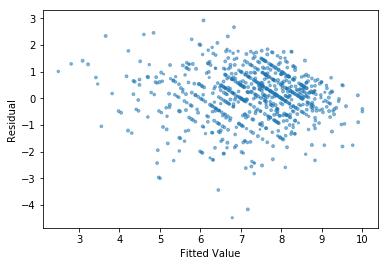

In [103]:
#let's also plot histogram of residuals vs fitted values

plt.scatter(predictionsdf3[0], predictionsdf3['resid'], y, alpha=0.5)
plt.ylabel('Residual')
plt.xlabel('Fitted Value')

In [104]:
#breakdown of residuals
predictionsdf3['resid'] = abs(predictionsdf3['resid'])
predictionsdf3['resid'].describe()

count    800.000000
mean       0.753071
std        0.621715
min        0.003507
25%        0.275686
50%        0.608067
75%        1.083868
max        4.486068
Name: resid, dtype: float64